# Model 1

This notebboks shows a basic usage example of the `Model1` for the railway scheduling problem. This model solves the railwayscheduling problem using the branch & bounds algorithm implemented in Gurobi with the prior addition that the simulated annealing meta-heuristic is used to generate an initial solution for the problem.

To initialize the model the following imports are needed.

In [1]:
import os
import sys
import numpy as np
from railway import *

We then change the directory to the root folder of the project in order to correctly load the datasets.\
⚠ **WARNING**: change the path below, which might differ from mine, according to your file system setting in order to correctly load the datasets.

In [2]:
# Root folder directory
ROOT_DIR = "/home/marco/railway-scheduling"

# Set the current directory to root directory
os.chdir(ROOT_DIR)
sys.path.append(os.getcwd())
print(f"Current working directory: 📂 {os.getcwd()}")

Current working directory: 📂 /home/marco/railway-scheduling


We can then initialize the railway scheduling problem by loading one of the datasets present in the `datasets/` folder. To do so we need to define the parameters:

- `N`: number of nodes (stations), with $N \in \{10, 20, 40\}$
- `T`: time horizon, with $T \in \{10, 50, 100\}$
- `J`: number of jobs, with $J \in \{10, 40, 80\}$
- `P`: total number of passengers per arc, currently only $P = 2000$ is available
- `K`: number of alternative routes, currently only $K = 3$ is available

And the problem can be instantiated as follows. Notice that we use the same class as in the `Model0` notebook, the difference will be in which methods we call before the optimization step.

In [3]:
# Define problem parameters
N = 10
T = 10
J = 80
P = 2000
K = 3

# Name of the file to load
FILENAME = f"datasets/railway_N{N}_T{T}_J{J}_P{P}_K{K}.json"

# Instantiate the Railway object
rail = Railway.load(FILENAME)
rail.model.setParam('TimeLimit', 60)

# Print the model in summary
print(rail)

Set parameter Username
Set parameter LicenseID to value 2585388
Academic license - for non-commercial use only - expires 2025-11-15


Set parameter TimeLimit to value 60
Railway scheduling problem

Parameters:
N:  10 stations
T:  10 periods
J:  80 jobs
P:  2000 passengers
K:  3 alternative routes
Aj: 80 jobs with arcs
Ja: 37 arcs with jobs
C:  0 arcs unavailable simultaneously

Optimization model:
Variables:   0
Constraints: 0
Objective:   0.0
Status:      LOADED



Alternatively the model can be initialized using the default constructor rather than importing it from a dataset file:

```python
rail = Railway(N, T, J, P, K)
```

But then the other problem parameters such as stations coordinates or passengers' demands must be randomly generated with the `generate()` method. See the `apps/generate.py` file for an example on how to do that.

Now we want to generate a good initial solution `S` for the problem. To do it will be sufficient to just call the `generate_initial_solution()` method like so:

```python
S = rail.generate_initial_solution()
print(S)
```

However, for the sake of this example, in the following cell we will show the inner working of the implemented `simulated_annealing()` method explicitly to visualize how the initial solution is generated.

In [4]:
# Simulated annealing (SA) for intial solution generation

# First of all we set the parameters for the SA algorithm
T = 1000
c = 0.99
L = 1
max_iter = 1000

# Then we initialize a starting solution and the iteration counter
S = rail.generate_initial_solution()
iter = 0

# We also initialize a list to store the values of the objective function
_, _, _, _, v = rail.get_vars_from_times(S)
objective_values = [rail.get_objective_value(v)]

# Simulated annealing (SA) algorithm
while (T > 1e-6) and (iter < max_iter):
	for _ in range(L):
		# Generate a new (neighbor) solution
		S_new = rail.generate_neighbor_solution(S)

		# Get the solutions' variables
		_, _, _, _, v = rail.get_vars_from_times(S)
		_, _, _, _, v_new = rail.get_vars_from_times(S_new)

		# Compute the objective function values
		f = rail.get_objective_value(v)
		f_new = rail.get_objective_value(v_new)

		# Accept solution if it's better or with a certain probability
		if f_new <= f:
			S = S_new
			objective_values.append(f_new)
		else:
			p = np.exp((f - f_new) / T)
			if np.random.rand() < p:
				S = S_new
				objective_values.append(f_new)

	# Cool down the temperature
	T *= c

	# Increment the iteration counter
	iter += 1
 
# Final solution with SA
print(f"Total number of iterations:\t{iter}")
print(f"Initial solution with SA:\t{S}")
print(f"Objective value of initial solution:\t{objective_values[-1]}")

Total number of iterations:	1000
Initial solution with SA:	{1: 3, 2: 1, 3: 1, 4: 4, 5: 4, 6: 4, 7: 2, 8: 6, 9: 5, 10: 3, 11: 7, 12: 2, 13: 8, 14: 2, 15: 9, 16: 5, 17: 7, 18: 7, 19: 6, 20: 5, 21: 1, 22: 2, 23: 4, 24: 9, 25: 3, 26: 9, 27: 5, 28: 6, 29: 2, 30: 2, 31: 1, 32: 5, 33: 3, 34: 3, 35: 6, 36: 9, 37: 3, 38: 5, 39: 8, 40: 5, 41: 9, 42: 2, 43: 1, 44: 7, 45: 2, 46: 9, 47: 1, 48: 6, 49: 9, 50: 2, 51: 7, 52: 8, 53: 2, 54: 7, 55: 8, 56: 4, 57: 5, 58: 8, 59: 7, 60: 2, 61: 3, 62: 4, 63: 6, 64: 9, 65: 9, 66: 7, 67: 4, 68: 6, 69: 3, 70: 9, 71: 5, 72: 3, 73: 4, 74: 3, 75: 6, 76: 8, 77: 9, 78: 6, 79: 2, 80: 5}
Objective value of initial solution:	14992.521794475078


We can also plot the values of the objective function through the iterations of the simulated annealing algorithm to see the trend of the initial solution improvement.

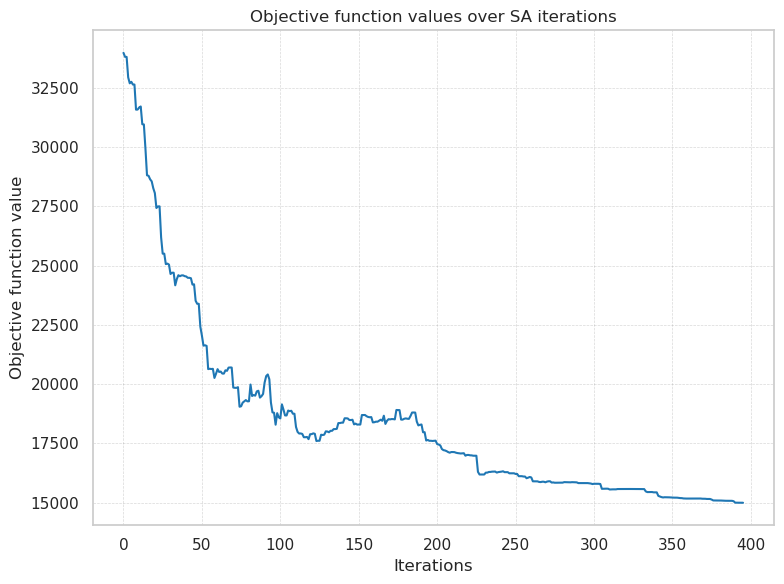

In [6]:
# Import and set style for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.5,
	},
)

# Plot the objective function values
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(len(objective_values)), y=objective_values)
plt.title("Objective function values over SA iterations")
plt.xlabel("Iterations")
plt.ylabel("Objective function value")
plt.grid(True)
plt.tight_layout()
plt.show()

Notice that the components of the `objective_values` list might be less than the total number of iterations because the neighbor solution is not always accepted during the SA algorithm...

After the initial solution has been generated through simulated annealing we can set it as the current solution of the problem with the `set_solution()` method, which internally sets the corresponding starting values for all the variables and runs the `update()` method required by Gurobi models for the changes to take effect.

In [7]:
# Set the initial solution
rail.set_solution(S)

Then, we can set the problem constraints and the objective function to minimize with the dedicated methods.

In [8]:
# Set constraints
rail.set_constraints()

# Set objective
rail.set_objective()

Finally the optimization can be run with the `optimize` method.

In [9]:
# Solve the scheduling problem
rail.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Arch Linux")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 8285 rows, 5700 columns and 24727 nonzeros
Model fingerprint: 0xe2970072
Variable types: 1450 continuous, 4250 integer (4250 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+06]
  Objective range  [1e+03, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 1e+06]

User MIP start produced solution with objective 14992.5 (0.02s)
Loaded user MIP start with objective 14992.5

Presolve removed 5806 rows and 3956 columns
Presolve time: 0.25s
Presolved: 2479 rows, 1744 columns, 9503 nonzeros
Found heuristic solution: objective 14942.617814
Variable types: 380 continuous, 1364 integer (1364 binary)

Root relaxation: objective 8.399367e+03, 1337 iterations, 0.02 seconds (0.

After the optimization we can compare the optimal solution found with the initial one generated by the simulated annealing algorithm to see how close it actually was.

In [11]:
# Compare initial solution and optimal one
print(f"Objective value of initial solution:\t{objective_values[-1]}")
print(f"Objective value of optimal solution:\t{rail.model.getObjective().getValue()}")

# Print initial solution schedule and optimal one
print(f"Initial solution schedule:\t {S}")
print(f"Optimal solution schedule:\t {rail.S}")

Objective value of initial solution:	14992.521794475078
Objective value of optimal solution:	14590.799574646244
Initial solution schedule:	 {1: 3, 2: 1, 3: 1, 4: 4, 5: 4, 6: 4, 7: 2, 8: 6, 9: 5, 10: 3, 11: 7, 12: 2, 13: 8, 14: 2, 15: 9, 16: 5, 17: 7, 18: 7, 19: 6, 20: 5, 21: 1, 22: 2, 23: 4, 24: 9, 25: 3, 26: 9, 27: 5, 28: 6, 29: 2, 30: 2, 31: 1, 32: 5, 33: 3, 34: 3, 35: 6, 36: 9, 37: 3, 38: 5, 39: 8, 40: 5, 41: 9, 42: 2, 43: 1, 44: 7, 45: 2, 46: 9, 47: 1, 48: 6, 49: 9, 50: 2, 51: 7, 52: 8, 53: 2, 54: 7, 55: 8, 56: 4, 57: 5, 58: 8, 59: 7, 60: 2, 61: 3, 62: 4, 63: 6, 64: 9, 65: 9, 66: 7, 67: 4, 68: 6, 69: 3, 70: 9, 71: 5, 72: 3, 73: 4, 74: 3, 75: 6, 76: 8, 77: 9, 78: 6, 79: 2, 80: 5}
Optimal solution schedule:	 {1: 9, 2: 5, 3: 5, 4: 4, 5: 2, 6: 4, 7: 2, 8: 2, 9: 5, 10: 8, 11: 3, 12: 8, 13: 9, 14: 7, 15: 8, 16: 4, 17: 3, 18: 3, 19: 1, 20: 5, 21: 6, 22: 6, 23: 4, 24: 3, 25: 3, 26: 7, 27: 5, 28: 1, 29: 6, 30: 2, 31: 5, 32: 1, 33: 9, 34: 9, 35: 6, 36: 6, 37: 9, 38: 2, 39: 9, 40: 7, 41: 1, 4